In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)




def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            X_new=np.moveaxis(X,-1,1)
#             X_new= X
            Y = load_img(mask_dir, mask_list[batch_start:limit])
            Y_new=np.moveaxis(Y,-1,1)

            yield (X_new,{'Dec_GT_Output':Y_new , 'Dec_VAE_Output':X_new} )#a tuple with two numpy arrays with batch_size samples    
#             yield (X_new,[ Y_new , X_new] )#a tuple with two numpy arrays with batch_size samples     


            batch_start += batch_size   
            batch_end += batch_size

############################################

In [4]:
!pwd

/content


In [5]:
import os

1854.603271484375
[0 1 2 4]
[0 1 2 3]
(240, 240)


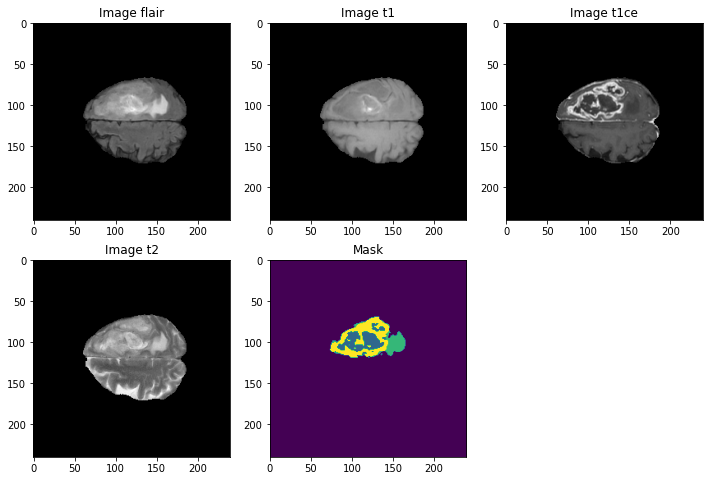

In [6]:

import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
##########################
#This part of the code to get an initial understanding of the dataset.
#################################
#PART 1: Load sample images and visualize
#Includes, dividing each image by its max to scale them to [0,1]
#Converting mask from float to uint8
#Changing mask pixel values (labels) from 4 to 3 (as the original labels are 0, 1, 2, 4)
#Visualize
###########################################
#View a few images

#Note: Segmented file name in Folder 355 has a weird name. Rename it to match others.
MY_PATH='/content/drive/MyDrive/Brats_2020_dataset'

TRAIN_DATASET_PATH =MY_PATH+ '/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
#VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
print(test_image_flair.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)


test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/W39_1998.09.19_Segm.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask)) 

import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
print(test_mask[:,:,n_slice].shape)
plt.title('Mask')
plt.show()

In [7]:
# # # images lists harley
#t1_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii'))
t2_list = sorted(glob.glob(TRAIN_DATASET_PATH+'*/*t2.nii'))
t1ce_list = sorted(glob.glob(TRAIN_DATASET_PATH+'*/*t1ce.nii'))
flair_list = sorted(glob.glob(TRAIN_DATASET_PATH+'*/*flair.nii'))
mask_list = sorted(glob.glob(TRAIN_DATASET_PATH+'*/*seg.nii'))


In [8]:
mask_list.insert(354,'/content/drive/MyDrive/Brats_2020_dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii')

In [9]:
len(flair_list)

369

In [10]:
len(mask_list)

369

In [11]:
mask_list[354]

'/content/drive/MyDrive/Brats_2020_dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii'

In [12]:
t1ce_list[44]

'/content/drive/MyDrive/Brats_2020_dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_045/BraTS20_Training_045_t1ce.nii'

In [13]:
# import os

# #Each volume generates 18 64x64x64x4 sub-volumes. 
# #Total 369 volumes = 6642 sub volumes

# for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
#     print("Now preparing image and masks number: ", img)
      
# #     temp_image_t2=nib.load(t2_list[img]).get_fdata()
# #     temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
 
#     temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
#     temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
#     #     print("temp_image_t1ce:",temp_image_t1ce.shape)

#     #     temp_image_flair=nib.load(flair_list[img]).get_fdata()
#     #     temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

#     temp_mask=nib.load(mask_list[img]).get_fdata()
#     temp_mask=temp_mask.astype(np.uint8)
#     temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
#     print(np.unique(temp_mask))


# #     temp_combined_images = np.stack([ temp_image_t1ce], axis=3)
#     temp_combined_images = temp_image_t1ce[...,np.newaxis]

#     #     print("temp_combined_images:",temp_combined_images.shape)

#         #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#         #cropping x, y, and z
#     temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
#     #     print("temp_combined_images_sliced:",temp_combined_images.shape)

#     temp_mask = temp_mask[56:184, 56:184, 13:141]

#     val, counts = np.unique(temp_mask, return_counts=True)

#     if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
#         print("Save Me")
#         temp_mask= to_categorical(temp_mask, num_classes=4)
#     #         os.mkdir('/kaggle/working/BraTS2020_TrainingData/hhhh')

# #         np.save('BraTS2020_TrainingData/images/image_'+str(img)+'.npy', temp_combined_images)
# #         np.save('BraTS2020_TrainingData/masks/mask_'+str(img)+'.npy', temp_mask)

#     else:
#         print("I am useless")

In [14]:
import os
import numpy as np


def load_img( img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
            
        temp_image_t1ce=nib.load(image_name).get_fdata()
        temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
        temp_combined_images = temp_image_t1ce[...,np.newaxis]
        temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
        images.append(temp_combined_images)
    images = np.array(images)
    
    return(images)

def load_mask( mask_list):
    masks=[]
    for i, image_name in enumerate(mask_list): 
        
        temp_mask=nib.load(image_name).get_fdata()
        temp_mask=temp_mask.astype(np.uint8)
        temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
        temp_mask = temp_mask[56:184, 56:184, 13:141]
        temp_mask= to_categorical(temp_mask, num_classes=4)
        
        masks.append(temp_mask)
    masks = np.array(masks)
    
    return(masks)



def imageLoader( img_list,  mask_list,batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_list[batch_start:limit])
            X_new=np.moveaxis(X,-1,1)
#             X_new= X
            Y = load_mask( mask_list[batch_start:limit])
            Y_new=np.moveaxis(Y,-1,1)

            yield (X_new,{'Dec_GT_Output':Y_new , 'Dec_VAE_Output':X_new} )#a tuple with two numpy arrays with batch_size samples    
#             yield (X_new,[ Y_new , X_new] )#a tuple with two numpy arrays with batch_size samples     


            batch_start += batch_size   
            batch_end += batch_size

############################################

In [15]:
# train_img_dir = "/kaggle/working/BraTS2020_TrainingData/images/"
# train_mask_dir = "/kaggle/working/BraTS2020_TrainingData/masks/"
# train_img_list=os.listdir(train_img_dir)
# train_mask_list = os.listdir(train_mask_dir)
batch_size=3

train_img_datagen = imageLoader(t1ce_list,mask_list, batch_size)

In [16]:
x,y = train_img_datagen.__next__()

In [17]:
x.shape

(3, 1, 128, 128, 128)

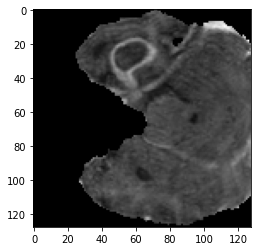

In [18]:
n_slice=34
plt.imshow(x[0,0,:,:,n_slice], cmap='gray')

In [19]:
y['Dec_GT_Output'].shape

(3, 4, 128, 128, 128)

In [20]:
np.unique(y['Dec_GT_Output'])

array([0., 1.], dtype=float32)

In [21]:
y_mask= np.argmax(y['Dec_GT_Output'],axis=1)
print(y_mask.shape)
print(np.unique(y_mask))

(3, 128, 128, 128)
[0 1 2 3]


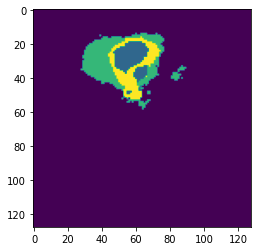

In [22]:
plt.imshow(y_mask[0,:,:,n_slice])

In [23]:
y['Dec_VAE_Output'].shape

(3, 1, 128, 128, 128)

In [24]:
# for i in train_img_datagen:
#     print(i.shape)

In [25]:
from  tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from tensorflow.keras import backend as K

from keras.utils.generic_utils import get_custom_objects


class GroupNormalization(Layer):
    """Group normalization layer
    Group Normalization divides the channels into groups and computes within each group
    the mean and variance for normalization. GN's computation is independent of batch sizes,
    and its accuracy is stable in a wide range of batch sizes
    # Arguments
        groups: Integer, the number of groups for Group Normalization.
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `BatchNormalization`.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as input.
    # References
        - [Group Normalization](https://arxiv.org/abs/1803.08494)
    """

    def __init__(self,
                 groups=32,
                 axis=-1,
                 epsilon=1e-5,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(GroupNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.groups = groups
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        dim = input_shape[self.axis]

        if dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of '
                             'input tensor should have a defined dimension '
                             'but the layer received an input with shape ' +
                             str(input_shape) + '.')

        if dim < self.groups:
            raise ValueError('Number of groups (' + str(self.groups) + ') cannot be '
                             'more than the number of channels (' +
                             str(dim) + ').')

        if dim % self.groups != 0:
            raise ValueError('Number of groups (' + str(self.groups) + ') must be a '
                             'multiple of the number of channels (' +
                             str(dim) + ').')

        self.input_spec = InputSpec(ndim=len(input_shape),
                                    axes={self.axis: dim})
        shape = (dim,)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, **kwargs):
        input_shape = K.int_shape(inputs)
        tensor_input_shape = K.shape(inputs)

        # Prepare broadcasting shape.
        reduction_axes = list(range(len(input_shape)))
        del reduction_axes[self.axis]
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
        broadcast_shape.insert(1, self.groups)

        reshape_group_shape = K.shape(inputs)
        group_axes = [reshape_group_shape[i] for i in range(len(input_shape))]
        group_axes[self.axis] = input_shape[self.axis] // self.groups
        group_axes.insert(1, self.groups)

        # reshape inputs to new group shape
        group_shape = [group_axes[0], self.groups] + group_axes[2:]
        group_shape = K.stack(group_shape)
        inputs = K.reshape(inputs, group_shape)

        group_reduction_axes = list(range(len(group_axes)))
        group_reduction_axes = group_reduction_axes[2:]

        mean = K.mean(inputs, axis=group_reduction_axes, keepdims=True)
        variance = K.var(inputs, axis=group_reduction_axes, keepdims=True)

        inputs = (inputs - mean) / (K.sqrt(variance + self.epsilon))

        # prepare broadcast shape
        inputs = K.reshape(inputs, group_shape)
        outputs = inputs

        # In this case we must explicitly broadcast all parameters.
        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            outputs = outputs * broadcast_gamma

        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            outputs = outputs + broadcast_beta

        outputs = K.reshape(outputs, tensor_input_shape)

        return outputs

    def get_config(self):
        config = {
            'groups': self.groups,
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(GroupNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape


In [26]:
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse
from tensorflow.keras.layers import Conv3D, Activation, Add, UpSampling3D, Lambda, Dense
from tensorflow.keras.layers import Input, Reshape, Flatten, Dropout, SpatialDropout3D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
# try:
#     from group_norm import GroupNormalization
# except ImportError:
#     import urllib.request
#     print('Downloading group_norm.py in the current directory...')
#     url = 'https://raw.githubusercontent.com/titu1994/Keras-Group-Normalization/master/group_norm.py'
#     urllib.request.urlretrieve(url, "group_norm.py")
#     from group_norm import GroupNormalization


def green_block(inp, filters, data_format='channels_first', name=None):
    """
    green_block(inp, filters, name=None)
    ------------------------------------
    Implementation of the special residual block used in the paper. The block
    consists of two (GroupNorm --> ReLu --> 3x3x3 non-strided Convolution)
    units, with a residual connection from the input `inp` to the output. Used
    internally in the model. Can be used independently as well.
    Parameters
    ----------
    `inp`: An keras.layers.layer instance, required
        The keras layer just preceding the green block.
    `filters`: integer, required
        No. of filters to use in the 3D convolutional block. The output
        layer of this green block will have this many no. of channels.
    `data_format`: string, optional
        The format of the input data. Must be either 'chanels_first' or
        'channels_last'. Defaults to `channels_first`, as used in the paper.
    `name`: string, optional
        The name to be given to this green block. Defaults to None, in which
        case, keras uses generated names for the involved layers. If a string
        is provided, the names of individual layers are generated by attaching
        a relevant prefix from [GroupNorm_, Res_, Conv3D_, Relu_, ], followed
        by _1 or _2.
    Returns
    -------
    `out`: A keras.layers.Layer instance
        The output of the green block. Has no. of channels equal to `filters`.
        The size of the rest of the dimensions remains same as in `inp`.
    """
    inp_res = Conv3D(
        filters=filters,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format=data_format,
        name=f'Res_{name}' if name else None)(inp)

    # axis=1 for channels_first data format
    # No. of groups = 8, as given in the paper
    x = GroupNormalization(
        groups=8,
        axis=1 if data_format == 'channels_first' else 0,
        name=f'GroupNorm_1_{name}' if name else None)(inp)
    x = Activation('relu', name=f'Relu_1_{name}' if name else None)(x)
    x = Conv3D(
        filters=filters,
        kernel_size=(3, 3, 3),
        strides=1,
        padding='same',
        data_format=data_format,
        name=f'Conv3D_1_{name}' if name else None)(x)

    x = GroupNormalization(
        groups=8,
        axis=1 if data_format == 'channels_first' else 0,
        name=f'GroupNorm_2_{name}' if name else None)(x)
    x = Activation('relu', name=f'Relu_2_{name}' if name else None)(x)
    x = Conv3D(
        filters=filters,
        kernel_size=(3, 3, 3),
        strides=1,
        padding='same',
        data_format=data_format,
        name=f'Conv3D_2_{name}' if name else None)(x)

    out = Add(name=f'Out_{name}' if name else None)([x, inp_res])
    return out


# From keras-team/keras/blob/master/examples/variational_autoencoder.py
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_var) * epsilon


def dice_coefficient(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[-3,-2,-1])
    dn = K.sum(K.square(y_true) + K.square(y_pred), axis=[-3,-2,-1]) + 1e-8
    return K.mean(2 * intersection / dn, axis=[0,1])


def loss_gt(e=1e-8):
    """
    loss_gt(e=1e-8)
    ------------------------------------------------------
    Since keras does not allow custom loss functions to have arguments
    other than the true and predicted labels, this function acts as a wrapper
    that allows us to implement the custom loss used in the paper. This function
    only calculates - L<dice> term of the following equation. (i.e. GT Decoder part loss)
    
    L = - L<dice> + weight_L2 ∗ L<L2> + weight_KL ∗ L<KL>
    
    Parameters
    ----------
    `e`: Float, optional
        A small epsilon term to add in the denominator to avoid dividing by
        zero and possible gradient explosion.
        
    Returns
    -------
    loss_gt_(y_true, y_pred): A custom keras loss function
        This function takes as input the predicted and ground labels, uses them
        to calculate the dice loss.
        
    """
    def loss_gt_(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[-3,-2,-1])
        dn = K.sum(K.square(y_true) + K.square(y_pred), axis=[-3,-2,-1]) + e
        
        return - K.mean(2 * intersection / dn, axis=[0,1])
    
    return loss_gt_

def loss_VAE(input_shape, z_mean, z_var, weight_L2=0.1, weight_KL=0.1):
    """
    loss_VAE(input_shape, z_mean, z_var, weight_L2=0.1, weight_KL=0.1)
    ------------------------------------------------------
    Since keras does not allow custom loss functions to have arguments
    other than the true and predicted labels, this function acts as a wrapper
    that allows us to implement the custom loss used in the paper. This function
    calculates the following equation, except for -L<dice> term. (i.e. VAE decoder part loss)
    
    L = - L<dice> + weight_L2 ∗ L<L2> + weight_KL ∗ L<KL>
    
    Parameters
    ----------
     `input_shape`: A 4-tuple, required
        The shape of an image as the tuple (c, H, W, D), where c is
        the no. of channels; H, W and D is the height, width and depth of the
        input image, respectively.
    `z_mean`: An keras.layers.Layer instance, required
        The vector representing values of mean for the learned distribution
        in the VAE part. Used internally.
    `z_var`: An keras.layers.Layer instance, required
        The vector representing values of variance for the learned distribution
        in the VAE part. Used internally.
    `weight_L2`: A real number, optional
        The weight to be given to the L2 loss term in the loss function. Adjust to get best
        results for your task. Defaults to 0.1.
    `weight_KL`: A real number, optional
        The weight to be given to the KL loss term in the loss function. Adjust to get best
        results for your task. Defaults to 0.1.
        
    Returns
    -------
    loss_VAE_(y_true, y_pred): A custom keras loss function
        This function takes as input the predicted and ground labels, uses them
        to calculate the L2 and KL loss.
        
    """
    def loss_VAE_(y_true, y_pred):
        c, H, W, D = input_shape
        n = c * H * W * D
        
        loss_L2 = K.mean(K.square(y_true - y_pred), axis=(1, 2, 3, 4)) # original axis value is (1,2,3,4).

        loss_KL = (1 / n) * K.sum(
            K.exp(z_var) + K.square(z_mean) - 1. - z_var,
            axis=-1
        )

        return weight_L2 * loss_L2 + weight_KL * loss_KL

    return loss_VAE_

def build_model(input_shape=(1, 160, 192, 128), output_channels=4, weight_L2=0.1, weight_KL=0.1, dice_e=1e-8):
    """
    build_model(input_shape=(4, 160, 192, 128), output_channels=3, weight_L2=0.1, weight_KL=0.1)
    -------------------------------------------
    Creates the model used in the BRATS2018 winning solution
    by Myronenko A. (https://arxiv.org/pdf/1810.11654.pdf)
    Parameters
    ----------
    `input_shape`: A 4-tuple, optional.
        Shape of the input image. Must be a 4D image of shape (c, H, W, D),
        where, each of H, W and D are divisible by 2^4, and c is divisible by 4.
        Defaults to the crop size used in the paper, i.e., (4, 160, 192, 128).
    `output_channels`: An integer, optional.
        The no. of channels in the output. Defaults to 3 (BraTS 2018 format).
    `weight_L2`: A real number, optional
        The weight to be given to the L2 loss term in the loss function. Adjust to get best
        results for your task. Defaults to 0.1.
    `weight_KL`: A real number, optional
        The weight to be given to the KL loss term in the loss function. Adjust to get best
        results for your task. Defaults to 0.1.
    `dice_e`: Float, optional
        A small epsilon term to add in the denominator of dice loss to avoid dividing by
        zero and possible gradient explosion. This argument will be passed to loss_gt function.
    Returns
    -------
    `model`: A keras.models.Model instance
        The created model.
    """
    c,H, W, D = input_shape
    assert len(input_shape) == 4, "Input shape must be a 4-tuple"
#     assert (c % 4) == 0, "The no. of channels must be divisible by 4"
    assert (H % 16) == 0 and (W % 16) == 0 , \
        "All the input dimensions must be divisible by 16"


    # -------------------------------------------------------------------------
    # Encoder
    # -------------------------------------------------------------------------

    ## Input Layer
    inp = Input(input_shape)

    ## The Initial Block
    x = Conv3D(
        filters=32,
        kernel_size=(3, 3, 3),
        strides=1,
        padding='same',
        data_format='channels_first',
        name='Input_x1')(inp)

    ## Dropout (0.2)
    x = SpatialDropout3D(0.2, data_format='channels_first')(x)

    ## Green Block x1 (output filters = 32)
    x1 = green_block(x, 32, name='x1')
    x = Conv3D(
        filters=32,
        kernel_size=(3, 3, 3),
        strides=2,
        padding='same',
        data_format='channels_first',
        name='Enc_DownSample_32')(x1)

    ## Green Block x2 (output filters = 64)
    x = green_block(x, 64, name='Enc_64_1')
    x2 = green_block(x, 64, name='x2')
    x = Conv3D(
        filters=64,
        kernel_size=(3, 3, 3),
        strides=2,
        padding='same',
        data_format='channels_first',
        name='Enc_DownSample_64')(x2)

    ## Green Blocks x2 (output filters = 128)
    x = green_block(x, 128, name='Enc_128_1')
    x3 = green_block(x, 128, name='x3')
    x = Conv3D(
        filters=128,
        kernel_size=(3, 3, 3),
        strides=2,
        padding='same',
        data_format='channels_first',
        name='Enc_DownSample_128')(x3)

    ## Green Blocks x4 (output filters = 256)
    x = green_block(x, 256, name='Enc_256_1')
    x = green_block(x, 256, name='Enc_256_2')
    x = green_block(x, 256, name='Enc_256_3')
    x4 = green_block(x, 256, name='x4')

    # -------------------------------------------------------------------------
    # Decoder
    # -------------------------------------------------------------------------

    ## GT (Groud Truth) Part
    # -------------------------------------------------------------------------

    ### Green Block x1 (output filters=128)
    x = Conv3D(
        filters=128,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        name='Dec_GT_ReduceDepth_128')(x4)
    x = UpSampling3D(
        size=2,
        data_format='channels_first',
        name='Dec_GT_UpSample_128')(x)
    x = Add(name='Input_Dec_GT_128')([x, x3])
    x = green_block(x, 128, name='Dec_GT_128')

    ### Green Block x1 (output filters=64)
    x = Conv3D(
        filters=64,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        name='Dec_GT_ReduceDepth_64')(x)
    x = UpSampling3D(
        size=2,
        data_format='channels_first',
        name='Dec_GT_UpSample_64')(x)
    x = Add(name='Input_Dec_GT_64')([x, x2])
    x = green_block(x, 64, name='Dec_GT_64')

    ### Green Block x1 (output filters=32)
    x = Conv3D(
        filters=32,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        name='Dec_GT_ReduceDepth_32')(x)
    x = UpSampling3D(
        size=2,
        data_format='channels_first',
        name='Dec_GT_UpSample_32')(x)
    x = Add(name='Input_Dec_GT_32')([x, x1])
    x = green_block(x, 32, name='Dec_GT_32')

    ### Blue Block x1 (output filters=32)
    x = Conv3D(
        filters=32,
        kernel_size=(3, 3, 3),
        strides=1,
        padding='same',
        data_format='channels_first',
        name='Input_Dec_GT_Output')(x)

    ### Output Block
    out_GT = Conv3D(
        filters=output_channels,  # No. of tumor classes is 3
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        activation='sigmoid',
        name='Dec_GT_Output')(x)

    ## VAE (Variational Auto Encoder) Part
    # -------------------------------------------------------------------------

    ### VD Block (Reducing dimensionality of the data)
    x = GroupNormalization(groups=8, axis=1, name='Dec_VAE_VD_GN')(x4)
    x = Activation('relu', name='Dec_VAE_VD_relu')(x)
    x = Conv3D(
        filters=16,
        kernel_size=(3, 3, 3),
        strides=2,
        padding='same',
        data_format='channels_first',
        name='Dec_VAE_VD_Conv3D')(x)

    # Not mentioned in the paper, but the author used a Flattening layer here.
    x = Flatten(name='Dec_VAE_VD_Flatten')(x)
    x = Dense(256, name='Dec_VAE_VD_Dense')(x)

    ### VDraw Block (Sampling)
    z_mean = Dense(128, name='Dec_VAE_VDraw_Mean')(x)
    z_var = Dense(128, name='Dec_VAE_VDraw_Var')(x)
    x = Lambda(sampling, name='Dec_VAE_VDraw_Sampling')([z_mean, z_var])

    ### VU Block (Upsizing back to a depth of 256)
    x = Dense((c//1) * (H//16) * (W//16) * (D//16))(x)
    x = Activation('relu')(x)
    x = Reshape(((c//1), (H//16), (W//16), (D//16)))(x)
    x = Conv3D(
        filters=256,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        name='Dec_VAE_ReduceDepth_256')(x)
    x = UpSampling3D(
        size=2,
        data_format='channels_first',
        name='Dec_VAE_UpSample_256')(x)

    ### Green Block x1 (output filters=128)
    x = Conv3D(
        filters=128,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        name='Dec_VAE_ReduceDepth_128')(x)
    x = UpSampling3D(
        size=2,
        data_format='channels_first',
        name='Dec_VAE_UpSample_128')(x)
    x = green_block(x, 128, name='Dec_VAE_128')

    ### Green Block x1 (output filters=64)
    x = Conv3D(
        filters=64,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        name='Dec_VAE_ReduceDepth_64')(x)
    x = UpSampling3D(
        size=2,
        data_format='channels_first',
        name='Dec_VAE_UpSample_64')(x)
    x = green_block(x, 64, name='Dec_VAE_64')

    ### Green Block x1 (output filters=32)
    x = Conv3D(
        filters=32,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        name='Dec_VAE_ReduceDepth_32')(x)
    x = UpSampling3D(
        size=2,
        data_format='channels_first',
        name='Dec_VAE_UpSample_32')(x)
    x = green_block(x, 32, name='Dec_VAE_32')

    ### Blue Block x1 (output filters=32)
    x = Conv3D(
        filters=32,
        kernel_size=(3, 3, 3),
        strides=1,
        padding='same',
        data_format='channels_first',
        name='Input_Dec_VAE_Output')(x)

    ### Output Block
    out_VAE = Conv3D(
        filters=1,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        name='Dec_VAE_Output')(x) 

    # Build and Compile the model
    out = out_GT
    model = Model(inp, outputs=[out, out_VAE])  # Create the model
    model.compile(
        Adam(learning_rate=1e-5),
        [loss_gt(dice_e), loss_VAE(input_shape, z_mean, z_var, weight_L2=weight_L2, weight_KL=weight_KL)],
        metrics=[dice_coefficient]
    )

    return model
    

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( t1ce_list, mask_list, test_size=0.10, shuffle = True,random_state=42)

In [28]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

332
332
37
37


In [29]:
print(X_train[66])
print(y_train[66])


/content/drive/MyDrive/Brats_2020_dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_259/BraTS20_Training_259_t1ce.nii
/content/drive/MyDrive/Brats_2020_dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_259/BraTS20_Training_259_seg.nii


In [30]:
batch_size=1

train_img_datagen = imageLoader(X_train,y_train, batch_size)


val_img_datagen = imageLoader(X_test,y_test, batch_size)

In [31]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [32]:
model = build_model(input_shape=( 1, 128, 128, 128), output_channels=4)

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 128, 128  0           []                               
                                , 128)]                                                           
                                                                                                  
 Input_x1 (Conv3D)              (None, 32, 128, 128  896         ['input_1[0][0]']                
                                , 128)                                                            
                                                                                                  
 spatial_dropout3d (SpatialDrop  (None, 32, 128, 128  0          ['Input_x1[0][0]']               
 out3D)                         , 128)                                                        

In [34]:
# os.mkdir('/content/drive/MyDrive/Colab Notebooks/Deep_learning_project/3d_unet_VAE/check_point')

In [39]:
import tensorflow as tf
checkpoint_filepath = '/content/drive/MyDrive/3d_unet_VAE/new_weights/3d_unet_VAE_weights'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    save_freq='epoch',
    save_weights_only=True,
    )

In [40]:
# import tensorflow._api.v2.compat.v1 as tf

# tf.disable_v2_behavior()

In [41]:
model.load_weights('/content/drive/MyDrive/3d_unet_VAE/new_weights/3d_unet_VAE_weights')

In [42]:
history = model.fit(train_img_datagen, validation_data=val_img_datagen, epochs=15,steps_per_epoch=len(X_train)//batch_size, validation_steps=len(X_test),callbacks=[model_checkpoint_callback])
# ,steps_per_epoch=369 

Epoch 1/15
332/332 [==============================] - ETA: 0s - batch: 165.5000 - size: 1.0000 - loss: -0.7940 - Dec_GT_Output_loss: -0.7955 - Dec_VAE_Output_loss: 0.0015 - Dec_GT_Output_dice_coefficient: 0.7955 - Dec_VAE_Output_dice_coefficient: 0.9121

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


332/332 [==============================] - 1380s 4s/step - batch: 165.5000 - size: 1.0000 - loss: -0.7940 - Dec_GT_Output_loss: -0.7955 - Dec_VAE_Output_loss: 0.0015 - Dec_GT_Output_dice_coefficient: 0.7955 - Dec_VAE_Output_dice_coefficient: 0.9121 - val_loss: -0.6932 - val_Dec_GT_Output_loss: -0.6947 - val_Dec_VAE_Output_loss: 0.0015 - val_Dec_GT_Output_dice_coefficient: 0.6947 - val_Dec_VAE_Output_dice_coefficient: 0.9056
Epoch 2/15
332/332 [==============================] - 1204s 4s/step - batch: 165.5000 - size: 1.0000 - loss: -0.8031 - Dec_GT_Output_loss: -0.8045 - Dec_VAE_Output_loss: 0.0015 - Dec_GT_Output_dice_coefficient: 0.8045 - Dec_VAE_Output_dice_coefficient: 0.9114 - val_loss: -0.6872 - val_Dec_GT_Output_loss: -0.6888 - val_Dec_VAE_Output_loss: 0.0016 - val_Dec_GT_Output_dice_coefficient: 0.6888 - val_Dec_VAE_Output_dice_coefficient: 0.9037
Epoch 3/15
332/332 [==============================] - 1207s 4s/step - batch: 165.5000 - size: 1.0000 - loss: -0.8024 - Dec_GT_Output_

### Evaluation

In [159]:
results=  model.evaluate(val_img_datagen,steps=len(X_test))
print(results)

[-0.7083770793837469, -0.70999795, 0.0016208108, 0.70999795, 0.8810073]


In [126]:
print(X_test[13])
print(y_test[13])
inferance_vol=[X_test[13]]
inferance_mask=[y_test[13]]

/content/drive/MyDrive/Brats_2020_dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_056/BraTS20_Training_056_t1ce.nii
/content/drive/MyDrive/Brats_2020_dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_056/BraTS20_Training_056_seg.nii


In [127]:
train_img_datagen = imageLoader(inferance_vol,inferance_mask, batch_size)

In [128]:
x,y = train_img_datagen.__next__()

In [129]:
x= np.squeeze(x)
y= np.squeeze(y['Dec_GT_Output'])
y=np.moveaxis(y,0,-1)
y=np.argmax(y,axis=-1)
y.shape

(128, 128, 128)

In [132]:
pred = model.predict(x[np.newaxis,np.newaxis,...])

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [135]:
len(pred)

2

In [151]:
pred_mask= pred[0]
pred_image=pred[1]

In [152]:
print(pred_mask.shape)
print(pred_image.shape)


(1, 4, 128, 128, 128)
(1, 1, 128, 128, 128)


In [153]:
pred_mask= np.squeeze(pred_mask)
pred_mask=np.moveaxis(pred_mask,0,-1)
pred_mask=np.argmax(pred_mask,axis=-1)
pred_mask.shape

pred_image= np.squeeze(pred_image)
pred_image=np.moveaxis(pred_image,0,-1)
# pred_image=np.argmax(pred_image,axis=-1)
pred_image.shape

(128, 128, 128)

(128, 128)


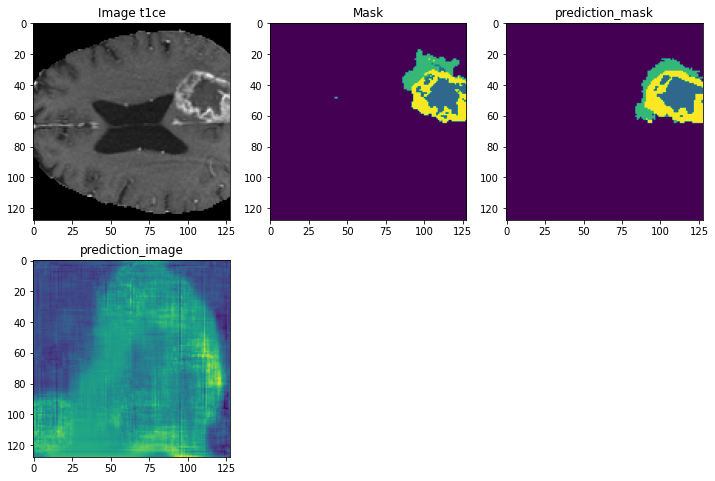

In [156]:
n_slice=80
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.imshow(x[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(232)
plt.imshow(y[:,:,n_slice])
print(y[:,:,n_slice].shape)
plt.title('Mask')
plt.subplot(233)
plt.imshow(pred_mask[:,:,n_slice])
plt.title('prediction_mask')
plt.subplot(234)
plt.imshow(pred_image[:,:,n_slice])
plt.title('prediction_image')
plt.show()